<a href="https://colab.research.google.com/github/Sandeep2017/Neural_Style_Transfer/blob/master/Neural_Style_Transfer_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras

Using TensorFlow backend.


In [0]:
from keras.preprocessing.image import load_img, img_to_array

In [0]:
from google.colab import drive

drive.mount('/content/drive')



In [4]:
import os
#print(os.listdir("/content/drive"))
local = 'drive/My Drive/N_Style'
print(os.listdir(local))

['Content.PNG', 'Style.PNG']


In [0]:
content_image_path = "drive/My Drive/N_Style/Content.PNG"
style_image_path = "drive/My Drive/N_Style/Style.PNG"

In [0]:
#Dimensions
width, height = load_img(content_image_path).size

In [7]:
print(width)
print(height)

692
375


In [0]:
img_height = 400
img_width = int(width * img_height / height)

In [0]:
import numpy as np
from keras.applications import vgg19


In [0]:
def preprocess_image(image_path):
  img = load_img(image_path, target_size = (img_height, img_width))
  img = img_to_array(img)
  img = np.expand_dims(img, axis =0)
  img = vgg19.preprocess_input(img)
  return img

In [0]:
def deprocess_image(X):
  # Removing zero-center by mean pixel
  X[:, :, 0] += 103.939
  X[:, :, 1] += 116.779
  X[:, :, 2] += 123.68
  # BGR -> RGB
  X = X[:, :, ::-1]
  X = np.clip(X, 0, 255).astype('uint8')
  return X 

In [0]:
from keras import backend as K

In [0]:
content_image = K.constant(preprocess_image(content_image_path))
style_image = K.constant(preprocess_image(style_image_path))

In [14]:
# This placeholder will contain our generated image
combination_image = K.placeholder((1, img_height, img_width, 3))

In [0]:
# We combine the 3 images into a single batch
input_tensor = K.concatenate([content_image,
                              style_image,
                              combination_image], axis = 0)

In [16]:
print(input_tensor)

Tensor("concat:0", shape=(3, 400, 738, 3), dtype=float32)


In [17]:
model = vgg19.VGG19(input_tensor = input_tensor,
                    weights = 'imagenet',
                    include_top = False)




80142336/80134624 [==============================] - 1s 0us/step








In [18]:
print(model.summary())

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [0]:
def content_loss(base, combination):
  return K.sum(K.square(combination - base))

In [0]:
def gram_matrix(x):
  features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
  gram = K.dot(features, K.transpose(features))
  return gram

In [0]:
def style_loss(style, combination):
  S = gram_matrix(style)
  C = gram_matrix(combination)
  channels = 3
  size = img_height * img_width
  return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [0]:
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [0]:
# Dict mapping layer names to activation tensors
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# Name of layer used for content loss
content_layer = 'block5_conv2'
# Name of layers used for style loss
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
# Weights in the weighted average of the loss components
#total_variation_weight = 1e-4
total_variation_weight = 1
style_weight = 40
content_weight = 0.90


In [95]:
# Define the loss by adding all components to a `loss` variable
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features,
                                      combination_features)

In [0]:
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)

In [0]:
# Get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)[0]

# Function to fetch the values of the current loss and the current gradients
fetch_loss_and_grads = K.function([combination_image], [loss, grads])

In [0]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [101]:
from scipy.optimize import fmin_l_bfgs_b
#from scipy.misc import imsave
import time
import PIL
import imageio
result_prefix = 'style_transfer_result'
iterations = 500

x = preprocess_image(content_image_path)
x = x.flatten()
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # Save current generated image
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    imageio.imwrite(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 50718015000.0
Image saved as style_transfer_result_at_iteration_0.png
Iteration 0 completed in 9s
Start of iteration 1
Current loss value: 28022424000.0
Image saved as style_transfer_result_at_iteration_1.png
Iteration 1 completed in 9s
Start of iteration 2
Current loss value: 19625982000.0
Image saved as style_transfer_result_at_iteration_2.png
Iteration 2 completed in 9s
Start of iteration 3
Current loss value: 15451605000.0
Image saved as style_transfer_result_at_iteration_3.png
Iteration 3 completed in 9s
Start of iteration 4
Current loss value: 12928305000.0
Image saved as style_transfer_result_at_iteration_4.png
Iteration 4 completed in 9s
Start of iteration 5
Current loss value: 10536283000.0
Image saved as style_transfer_result_at_iteration_5.png
Iteration 5 completed in 9s
Start of iteration 6
Current loss value: 9185978000.0
Image saved as style_transfer_result_at_iteration_6.png
Iteration 6 completed in 9s
Start of iteration 7
Current

KeyboardInterrupt: ignored

<Figure size 720x360 with 0 Axes>

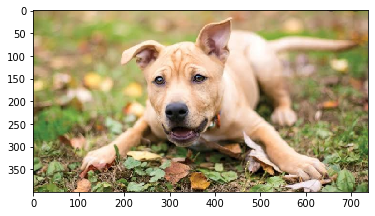

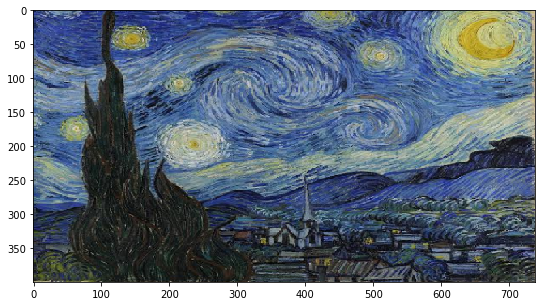

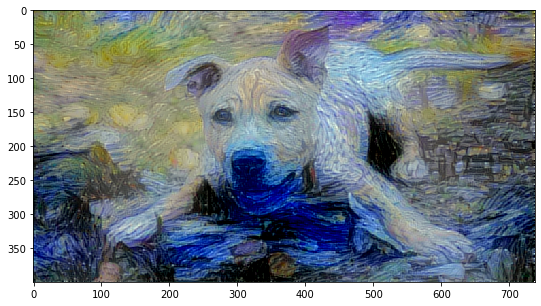

<Figure size 720x360 with 0 Axes>

In [134]:
from matplotlib import pyplot as plt
# Content image



plt.imshow(load_img(content_image_path, target_size=(img_height, img_width)))
plt.figure(figsize = (10,5))

# Style image
plt.imshow(load_img(style_image_path, target_size=(img_height, img_width)))

plt.figure(figsize = (10,5))



# Generate image
plt.imshow(img)
plt.figure(figsize = (10,5))